<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: Speed Dating

_Authors: Kiefer Katovich (SF)_

---

Let's practice principal component analysis (PCA) using a data set from Kaggle. PCA is often used to simplify data, reduce noise, and find unmeasured latent variables, so it's important to take the time to understand what's going on.

**In this lab, we will:**

- Explore how PCA relates to correlation.
- Use PCA to perform dimensionality reduction.
- Predict whether or not a speed dater likes reading based on the dater's other likes.

---

### Data Set

The data set we're using for this lab is a subset of this [much more detailed speed dating data set](https://www.kaggle.com/annavictoria/speed-dating-experiment). In particular, this contains no information on the actual speed dating itself (i.e., successes with or opinions of other individuals). 

It also contains no follow-up information where individuals are asked the same questions about themselves again. It only contains information about what an individual enjoys doing, their self-ratings on how desirable they are, and how they think others rate them based on desirability.

The columns present in the data are outlined below:

FieldName|Description
---------|-----------
    subject_id                   |   Unique individual identifier.
    wave                         |   Meetup ID.
    like_sports                  |   Enjoyment of participating in sports.
    like_tvsports                |   Enjoyment of watching sports on TV.
    like_exercise                |   Enjoyment of exercise.
    like_food                    |   Enjoyment of food.
    like_museums                 |   Enjoyment of museums.
    like_art                     |   Enjoyment of art.
    like_hiking                  |   Enjoyment of hiking.
    like_gaming                  |   Enjoyment of playing games.
    like_clubbing                |   Enjoyment of going clubbing/partying.
    like_reading                 |   Enjoyment of reading.
    like_tv                      |   Enjoyment of TV in general.
    like_theater                 |   Enjoyment of the theater (plays, musicals, etc.).
    like_movies                  |   Enjoyment of movies.
    like_concerts                |   Enjoyment of concerts.
    like_music                   |   Enjoyment of music.
    like_shopping                |   Enjoyment of shopping.
    like_yoga                    |   Enjoyment of yoga.
    subjective_attractiveness    |   How attractive they rate themselves.
    subjective_sincerity         |   How sincere they rate themselves.
    subjective_intelligence      |   How intelligent they rate themselves.
    subjective_fun               |   How fun they rate themselves.
    subjective_ambition          |   How ambitious they rate themselves.
    objective_attractiveness     |   Perceived rating others would give them on how attractive they are.
    objective_sincerity          |   Perceived rating others would give them on how sincere they are.
    objective_intelligence       |   Perceived rating others would give them on how intelligent they are.
    objective_fun                |   Perceived rating others would give them on how fun they are.
    objective_ambition           |   Perceived rating others would give them on how ambitious they are.
    
There are 551 subjects total.

---

### 1) Load packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

---

### 2) Load and clean the speed dating data.

- First, remove columns with more than 200 missing values.
- Then, remove rows with missing values.
- Verify that no rows contain NaNs.

In [2]:
sd = pd.read_csv('./datasets/speed_dating.csv')

# A: 
sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 551 non-null    int64  
 1   wave                       551 non-null    int64  
 2   like_sports                544 non-null    float64
 3   like_tvsports              544 non-null    float64
 4   like_exercise              544 non-null    float64
 5   like_food                  544 non-null    float64
 6   like_museums               544 non-null    float64
 7   like_art                   544 non-null    float64
 8   like_hiking                544 non-null    float64
 9   like_gaming                544 non-null    float64
 10  like_clubbing              544 non-null    float64
 11  like_reading               544 non-null    float64
 12  like_tv                    544 non-null    float64
 13  like_theater               544 non-null    float64

In [3]:
sd.isnull().sum()

subject_id                     0
wave                           0
like_sports                    7
like_tvsports                  7
like_exercise                  7
like_food                      7
like_museums                   7
like_art                       7
like_hiking                    7
like_gaming                    7
like_clubbing                  7
like_reading                   7
like_tv                        7
like_theater                   7
like_movies                    7
like_concerts                  7
like_music                     7
like_shopping                  7
like_yoga                      7
subjective_attractiveness      9
subjective_sincerity           9
subjective_intelligence        9
subjective_fun                 9
subjective_ambition            9
objective_attractiveness     237
objective_sincerity          237
objective_intelligence       237
objective_fun                237
objective_ambition           237
dtype: int64

In [4]:
# A:
sd = sd[sd.columns[sd.isnull().sum() < 200]]

In [5]:
sd = sd.dropna()

In [6]:
sd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542 entries, 0 to 550
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 542 non-null    int64  
 1   wave                       542 non-null    int64  
 2   like_sports                542 non-null    float64
 3   like_tvsports              542 non-null    float64
 4   like_exercise              542 non-null    float64
 5   like_food                  542 non-null    float64
 6   like_museums               542 non-null    float64
 7   like_art                   542 non-null    float64
 8   like_hiking                542 non-null    float64
 9   like_gaming                542 non-null    float64
 10  like_clubbing              542 non-null    float64
 11  like_reading               542 non-null    float64
 12  like_tv                    542 non-null    float64
 13  like_theater               542 non-null    float64

---

### 3) Example: Are the `subjective` columns correlated?

Here, we'll understand how the `subjective` columns are correlated.

- Find the z scores of each `subjective` column (i.e. standardize the `subjective` columns).
- Visualize correlation using [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html).
- Visualize correlation using a heat map.

**3.A) Find the z scores of each column. This allows the columns to more easily be directly compared.**

In [7]:
subjective_cols = [col for col in sd.columns \
                   if col.startswith('subjective')]
sd[subjective_cols].describe() # Before transform
# You can see that the attribute scaled from 1-10

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
count,542.000000,542.000000,542.000000,542.000000,542.000000
mean,7.092251,8.285978,8.385609,7.701107,7.577491
std,1.390081,1.412038,1.089700,1.547510,1.786293
min,2.000000,2.000000,3.000000,2.000000,2.000000
25%,6.000000,8.000000,8.000000,7.000000,7.000000
50%,7.000000,8.000000,8.000000,8.000000,8.000000
75%,8.000000,9.000000,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [8]:
# A:
sc = StandardScaler()
sd[subjective_cols] = sc.fit_transform(sd[subjective_cols]) # Transform to Z score

# Mean of 0, Std = 1

In [9]:
sd[subjective_cols].describe() # After transform -> Mean = 0 , Std = 1

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
count,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02
mean,-2.208156e-16,1.390851e-16,-4.629343e-16,3.728055e-17,2.285994e-16
std,1.000924e+00,1.000924e+00,1.000924e+00,1.000924e+00,1.000924e+00
min,-3.666661e+00,-4.455819e+00,-4.946854e+00,-3.687456e+00,-3.125268e+00
25%,-7.864723e-01,-2.027155e-01,-3.541940e-01,-4.534735e-01,-3.235888e-01
50%,-6.642502e-02,-2.027155e-01,-3.541940e-01,1.933229e-01,2.367470e-01
75%,6.536222e-01,5.061350e-01,5.643379e-01,8.401194e-01,7.970829e-01
max,2.093717e+00,1.214985e+00,1.482870e+00,1.486916e+00,1.357419e+00


**3.B) Use a PairGrid to visualize correlation.**

[`PairGrid`](https://seaborn.pydata.org/generated/seaborn.PairGrid.html) is more general version of `pairplot`.  For example, you could use the following code, where `subjective` is a data frame containing only the subjective columns:

```python
g = sns.PairGrid(subjective)
# Regression plots in lower triangle
g = g.map_lower(sns.regplot) 
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle
g = g.map_diag(plt.hist) # Histograms along diagonal

plt.show()
```

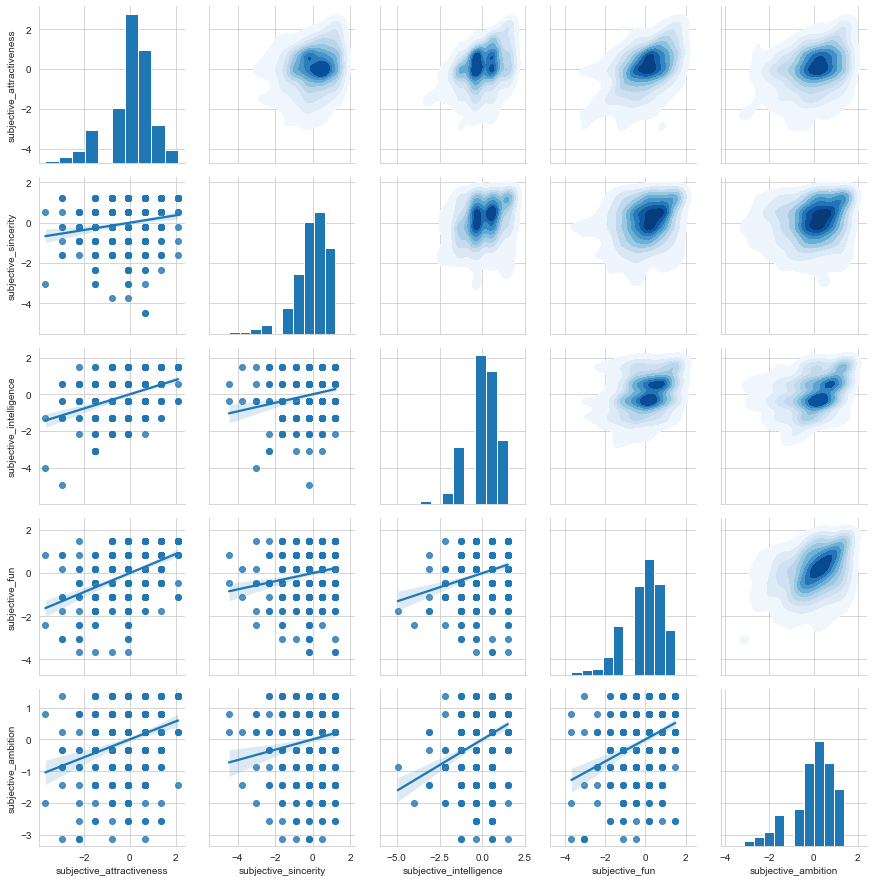

In [10]:
# A:
g = sns.PairGrid(sd[subjective_cols])
# Regression plots in lower triangle
g = g.map_lower(sns.regplot) 
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, thresh=0.05)  # KDE plots in upper triangle
g = g.map_diag(plt.hist) # Histograms along diagonal

plt.show()

**3.C) Use a heat map to visualize correlation.**

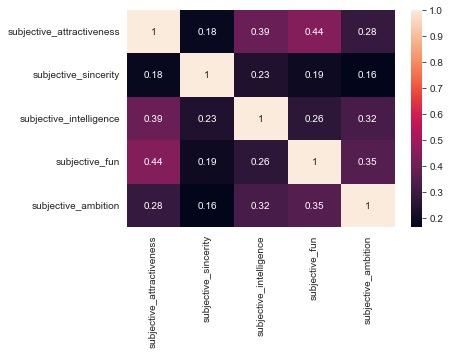

In [11]:
# A:
h = sns.heatmap(sd[subjective_cols].corr(), annot=True);
#plt.xticks(rotation=0);

In [12]:
# The highest correlated subjective traits are attraction and fun.
# This make sense if you are attracted to someone, it is likely to be due to
# the fun and enjoyable experience.

In [13]:
# All of the subjective traits have positive correlations.
# This can be interpreted as people with high score in one category tends to
# have all of the other subjective traits as well.

# It is unlikely to have very attractive person with low fun category.
# Moreover, this can be due to selection bias as low score (unattractive) person would
# not have the opportunity to elaborate the other aspects from the speed dating.

---

**Important: Did you ensure the results make sense intuitively?** If not, look at the results again. You should **always** interpret your results and ensure they make sense based on what you expected. If they don’t, investigate why — sometimes your analysis or data are wrong.

> For example, the results show that believing you are attractive and fun are correlated. Would you expect that believing you are intellectual and fun to have a higher or lower correlation? What do the results say?

---


### 4) Visualize some preference columns.

Next, we’ll explore how some preference ratings are correlated. You saw an example — now try it on the `preference_cols` below.

- Find the z scores of each column in `preference_cols`.
- Visualize correlation using PairGrid.
- Visualize correlation using a heat map.
- Do these results make sense intuitively? 

In [14]:
preference_cols = ['like_tvsports', 'like_sports', 'like_museums', 
                   'like_theater', 'like_shopping']
sd_like = sd[preference_cols]

**4.A) Find the z scores of each column in `preference_cols`.**

In [15]:
# A:
sc = StandardScaler()
sd[preference_cols] = sc.fit_transform(sd[preference_cols])

In [16]:
sd[preference_cols].describe()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
count,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02
mean,-1.050820e-16,8.808042e-17,-6.022243e-17,-2.844690e-17,2.396607e-16
std,1.000924e+00,1.000924e+00,1.000924e+00,1.000924e+00,1.000924e+00
min,-1.269983e+00,-2.053215e+00,-2.935051e+00,-2.560869e+00,-1.766472e+00
25%,-9.127799e-01,-8.158772e-01,-4.831434e-01,-7.876450e-01,-6.180178e-01
50%,-1.983731e-01,2.311008e-01,7.238103e-03,9.896682e-02,1.476180e-01
75%,8.732371e-01,6.118201e-01,8.654057e-01,9.855787e-01,9.132538e-01
max,1.944847e+00,1.373259e+00,1.478383e+00,1.428885e+00,1.678890e+00


**4.B) Visualize correlation using PairGrid.**

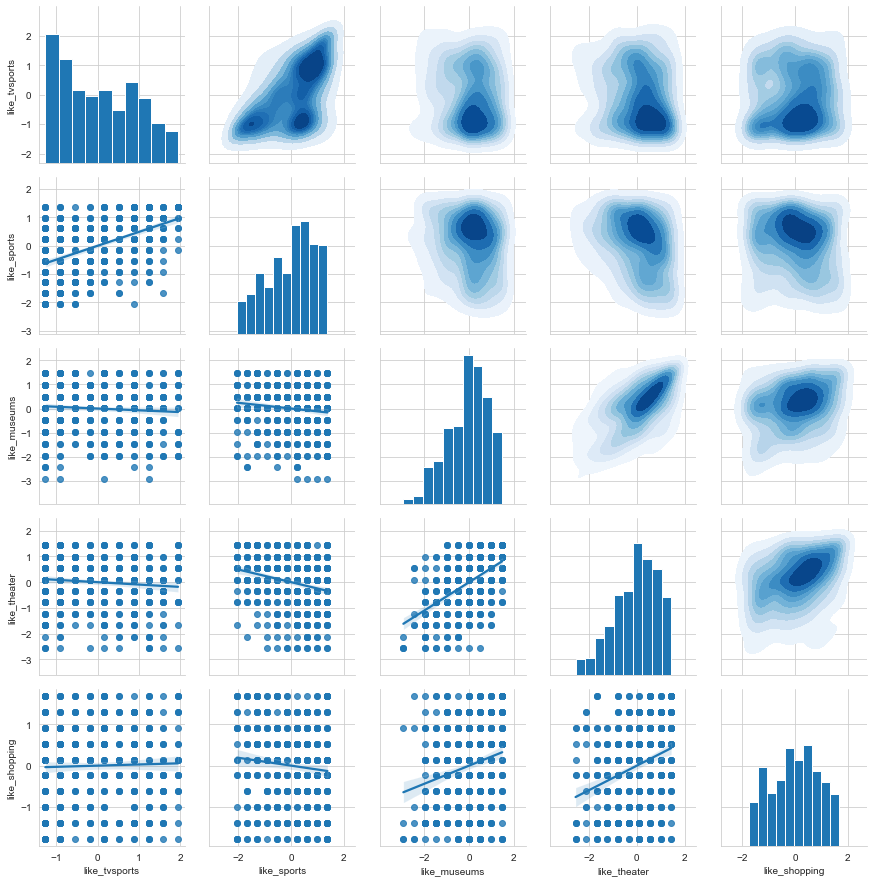

In [17]:
# A:
g2 = sns.PairGrid(sd[preference_cols])
# Regression plots in lower triangle
g2 = g2.map_lower(sns.regplot) 
g2 = g2.map_upper(sns.kdeplot, cmap="Blues", shade=True, thresh=0.05)  # KDE plots in upper triangle
g2 = g2.map_diag(plt.hist) # Histograms along diagonal

plt.show()

**4.C) Visualize correlation using a heat map.**

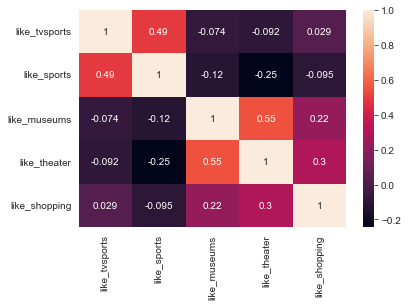

In [18]:
# A:
h2 = sns.heatmap(sd[preference_cols].corr(), annot=True);
#plt.xticks(rotation=0);

In [19]:
# Like_sports and Like_TVsports have a high positive correlation as expected.
# like_museum and like_theater have a high positive correlation as expected.
# like_shopping have a slight positive correlation with like_theater

---

### 5) Example: Fit PCA on the subjective ratings.

In [20]:
subjective_pca = PCA(n_components=5)
subjective_pca.fit(sd[subjective_cols].values)

PCA(n_components=5)

---

**5.A) Look at the weights of the principal components.**

The principal components (or eigenvectors!) are simply the weights or coefficients on the original variables $X$ that transforms them to $Z$.

In [21]:
# A: 

In [22]:
subjective_pca.components_ # Coefficients before transform

array([[-0.50189394, -0.31528977, -0.46707122, -0.48386412, -0.44318711],
       [ 0.21825979, -0.90905995, -0.09768977,  0.27400972,  0.20334221],
       [-0.40202351, -0.14438615,  0.42289342, -0.48141404,  0.63791176],
       [ 0.34811874, -0.21377638,  0.64842003, -0.36104737, -0.53132783],
       [-0.64626278, -0.08749096,  0.41594928,  0.57330577, -0.27017855]])

In [23]:
subjective_pca.components_.mean()

-0.10455010893012769

---

**5.B) Look at the explained variance values (aka eigenvalues) and the explained variance ratios.**

The eigenvalues are ordered such that the first components have the largest eigenvalues. The values and their normalized equivalent in the explained variance ratio attribute tell you how much of the variance in the original data is encapsulated in the new component variables.

In [24]:
# A:# Pull the explained variance attribute.
var_exp = subjective_pca.explained_variance_ratio_
print(f'Explained variance (first 5 components): \
{np.round(var_exp[:6], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 5 components): \
{np.round(cum_var_exp[:6], 3)}')

Explained variance (first 5 components): [0.431 0.178 0.147 0.144 0.1  ]

Cumulative explained variance (first 5 components): [0.431 0.609 0.756 0.9   1.   ]


---

**5.C) Transform the subjective data into the principal component space.**

The `transform()` function in the PCA will create your new component variable matrix.

In [25]:
# A:
Z_sub = subjective_pca.transform(sd[subjective_cols].values)
Z_sub

array([[ 0.673942  ,  0.03439955, -0.10382612, -0.35798348,  0.57693667],
       [ 1.35044583,  2.02341707, -2.13879048,  1.07112465,  1.64483811],
       [-0.94967947, -0.27146457, -0.03924025,  0.28967741, -0.18508884],
       ...,
       [ 1.27802939,  0.74844718, -0.36801805, -0.31785638, -0.5792599 ],
       [ 2.37402987, -0.92246551,  0.44869284,  1.6557433 , -1.43968236],
       [ 1.22960363,  0.72837603, -0.34611708,  0.16632973, -1.41541178]])

In [26]:
pd.DataFrame(Z_sub, columns= subjective_cols ).describe()

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
count,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02,5.420000e+02
mean,2.785799e-17,7.292240e-17,-2.959912e-17,6.646999e-17,3.687088e-18
std,1.469835e+00,9.430007e-01,8.591908e-01,8.498812e-01,7.064489e-01
min,-3.447558e+00,-2.816724e+00,-2.738694e+00,-3.089647e+00,-2.006640e+00
25%,-9.260940e-01,-6.487584e-01,-4.875799e-01,-4.922307e-01,-4.620885e-01
50%,-1.592723e-01,-9.536335e-02,-6.058270e-02,-4.272193e-02,-3.979378e-02
75%,9.449452e-01,5.061100e-01,5.070417e-01,5.218828e-01,4.415827e-01
max,6.726391e+00,4.530417e+00,3.446718e+00,3.722961e+00,2.663813e+00


This transformed our five-dimensional data set into vectors along its five principal components (with zero loss).
- Using these, we can now reduce the dimensionality of our data while minimizing loss.
- For example, taking only the first three eigenvectors accounts for `0.431 + 0.178 + 0.147 = 75.6%` of the variance.

In [27]:
# A: # Pull the explained variance attribute.
var_exp = subjective_pca.explained_variance_ratio_
print(f'Explained variance (first 5 components): \
{np.round(var_exp[:6], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 5 components): \
{np.round(cum_var_exp[:6], 3)}')

Explained variance (first 5 components): [0.431 0.178 0.147 0.144 0.1  ]

Cumulative explained variance (first 5 components): [0.431 0.609 0.756 0.9   1.   ]


---

**5.D) PCA-transformed features are not correlated.**

- Keep in mind that each column in the transformed data is no longer correlated.
- Compare this to the exploration above where many columns were correlated.

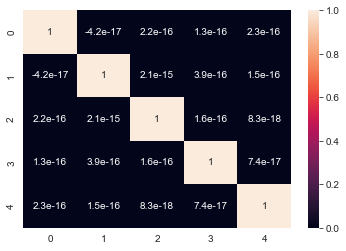

In [28]:
# A: 
sns.heatmap(pd.DataFrame(Z_sub).corr(), annot=True); # Z is no longer correlated

---

### 6) Optional: How were the data transformed?

To demonstrate how the new principal component matrix is created from the original variable columns and the eigenvector weighting matrix, we'll create the first component (PC1) manually.

**6.A) Pull out the eigenvector for PC1.**

In [29]:
# A:
eigen1 = subjective_pca.components_[0]
eigen1 # Weight of Z0 -> PC1

array([-0.50189394, -0.31528977, -0.46707122, -0.48386412, -0.44318711])

**6.B) Create a DataFrame showing the original values for the subjective variables for `person1`.**

In [30]:
#sd[subjective_cols][:1]

In [31]:
# A:
person1 = sd[subjective_cols][:1].T
person1

,0
subjective_attractiveness,-0.786472
subjective_sincerity,-0.202716
subjective_intelligence,-0.354194
subjective_fun,0.193323
subjective_ambition,-0.323589


**6.C) Add the eigenvector for PC1: the weights by which to multiply each original variable.**

Recall that each component is a linear combination of the original variables, multiplied by a "weight" defined in the eigenvector of that component.

In [32]:
eigenvector = sd[subjective_cols][:1].values.ravel()
eigenvector

array([-0.78647228, -0.20271555, -0.35419405,  0.19332293, -0.32358876])

In [33]:
person1.iloc[:,0]

subjective_attractiveness   -0.786472
subjective_sincerity        -0.202716
subjective_intelligence     -0.354194
subjective_fun               0.193323
subjective_ambition         -0.323589
Name: 0, dtype: float64

In [34]:
type(person1)

pandas.core.frame.DataFrame

In [35]:
# A: 
person1["eigenvector"] = subjective_pca.components_[0]

person1.head()

,0,eigenvector
subjective_attractiveness,-0.786472,-0.501894
subjective_sincerity,-0.202716,-0.315290
subjective_intelligence,-0.354194,-0.467071
subjective_fun,0.193323,-0.483864
subjective_ambition,-0.323589,-0.443187


**6.D) Multiply the original variable values by the eigenvector values.**

These are the "pieces" of PC1 that will be added together to create the new value for that person.

In [36]:
# A:
person1["newvalue"] = person1[0]*person1["eigenvector"]
person1

,0,eigenvector,newvalue
subjective_attractiveness,-0.786472,-0.501894,0.394726
subjective_sincerity,-0.202716,-0.315290,0.063914
subjective_intelligence,-0.354194,-0.467071,0.165434
subjective_fun,0.193323,-0.483864,-0.093542
subjective_ambition,-0.323589,-0.443187,0.143410


**6.E) Sum the original values multiplied by the eigenvector weights to get `person1`’s value for PC1.**

In [37]:
# A:
person1.sum()

0             -1.473648
eigenvector   -2.211306
newvalue       0.673942
dtype: float64

In [38]:
Z_sub

array([[ 0.673942  ,  0.03439955, -0.10382612, -0.35798348,  0.57693667],
       [ 1.35044583,  2.02341707, -2.13879048,  1.07112465,  1.64483811],
       [-0.94967947, -0.27146457, -0.03924025,  0.28967741, -0.18508884],
       ...,
       [ 1.27802939,  0.74844718, -0.36801805, -0.31785638, -0.5792599 ],
       [ 2.37402987, -0.92246551,  0.44869284,  1.6557433 , -1.43968236],
       [ 1.22960363,  0.72837603, -0.34611708,  0.16632973, -1.41541178]])

---

### 7) Fit PCA on the preference data.

Now that you've seen how it's done, try it yourself!

- Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.
- Transform the original `sd_like` columns into the principal component space.
- Verify that these columns are uncorrelated.

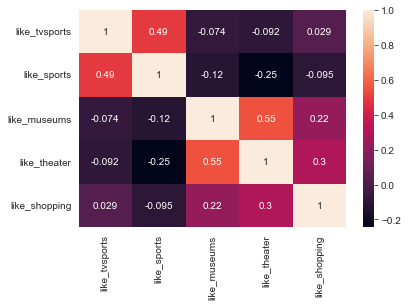

In [39]:
# A:
sns.heatmap(pd.DataFrame(sd[preference_cols]).corr(), annot=True); # Original

In [40]:
sd.columns

Index(['subject_id', 'wave', 'like_sports', 'like_tvsports', 'like_exercise',
       'like_food', 'like_museums', 'like_art', 'like_hiking', 'like_gaming',
       'like_clubbing', 'like_reading', 'like_tv', 'like_theater',
       'like_movies', 'like_concerts', 'like_music', 'like_shopping',
       'like_yoga', 'subjective_attractiveness', 'subjective_sincerity',
       'subjective_intelligence', 'subjective_fun', 'subjective_ambition'],
      dtype='object')

In [41]:
preference_pca = PCA(n_components=5)
preference_pca.fit(sd[preference_cols].values)

PCA(n_components=5)

#### 7.A) Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.

In [42]:
# A: 
preference_pca.components_ # Coefficients before transform

array([[ 3.20753112e-01,  4.30670129e-01, -5.13289220e-01,
        -5.73131676e-01, -3.45969565e-01],
       [ 6.49921628e-01,  5.32191987e-01,  3.24132297e-01,
         2.65063681e-01,  3.45040672e-01],
       [ 2.08050622e-05, -1.60309917e-01, -4.54907251e-01,
        -2.24216382e-01,  8.46809977e-01],
       [ 6.22451715e-01, -5.87488681e-01, -3.38227940e-01,
         3.33354423e-01, -2.04664607e-01],
       [ 2.95420347e-01, -4.00565486e-01,  5.56896475e-01,
        -6.63221810e-01,  4.77206044e-02]])

#### 7.B) Transform the original `sd_like` columns into the principal component space.

In [43]:
# A:# Pull the explained variance attribute.
var_exp = preference_pca.explained_variance_ratio_
print(f'Explained variance (first 5 components): \
{np.round(var_exp[:6], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 5 components): \
{np.round(cum_var_exp[:6], 3)}')

Explained variance (first 5 components): [0.382 0.268 0.164 0.104 0.082]

Cumulative explained variance (first 5 components): [0.382 0.65  0.814 0.918 1.   ]


#### 7.C) Verify that these columns are uncorrelated.

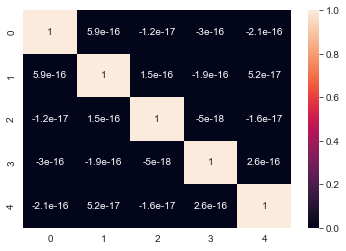

In [44]:
# A:
Z_like = preference_pca.transform(sd[preference_cols].values)
sns.heatmap(pd.DataFrame(Z_like).corr(), annot=True); # Z is no longer correlated

---

### 8) Use PCA for dimensionality reduction.

Using linear regression, let's predict whether or not a user likes reading.

**The key question:** Can we get the same prediction accuracy using only the first three principal components as features versus using all five original values as features?

In [45]:
# Set X and y
X = sd[preference_cols]
y = sd['like_reading'].values # Y (target)

**8.A) Linear regression cross-validated on original variables (`sd_like.values`).**

- What is the mean cross-validation score?
- Keep in mind that linear regression uses $R^2$ for score, so one is the ideal score.

In [46]:
# A:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [56]:
cross_val_score(lr,X,y,cv=5)

array([-0.00452896,  0.13167438,  0.02237835,  0.17929338,  0.13084444])

In [51]:
print(cross_val_score(lr,X,y,cv=5).mean())

0.09193231749299227


**8.B) Linear regression on the first principal component.**

- What is the mean cross-validation score?

In [49]:
# Instantiate PCA with 10 components.
pca1 = PCA(n_components=1, random_state=42)

# Fit PCA to training data.
pca1.fit(X)

PCA(n_components=1, random_state=42)

In [53]:
# A:
lr1 = LinearRegression()

# Transform Z_train and Z_test.
Z = pca1.transform(X)

# Fit on Z_train.
lr1.fit(Z, y)

# Cross Val Score on the model.
print(cross_val_score(lr1,Z,y,cv=5).mean())

0.05341726555351931


In [54]:
cross_val_score(lr1,Z,y,cv=5)

array([-0.0023653 ,  0.125695  , -0.04543447,  0.10281085,  0.08638025])

**8.C) Linear regression on first three principal components.**

- What is the mean cross-validation score?

In [58]:
# A:
# Instantiate PCA with 10 components.
pca3 = PCA(n_components=3, random_state=42)

# Fit PCA to training data.
pca3.fit(X)

PCA(n_components=3, random_state=42)

In [59]:
# A:
lr3 = LinearRegression()

# Transform Z_train and Z_test.
Z = pca3.transform(X)

# Fit on Z_train.
lr1.fit(Z, y)

# Cross Val Score on the model.
print(cross_val_score(lr3,Z,y,cv=5).mean())

0.0926139331079642


In [61]:
cross_val_score(lr3,Z,y,cv=5)

array([-0.03413068,  0.13162289,  0.04945168,  0.19108757,  0.12503821])

In [62]:
cross_val_score(lr3,Z,y,cv=5).mean() - cross_val_score(lr,X,y,cv=5).mean()

0.000681615614971931

---

**Check yourself**. The mean cross-validation score should be nearly the same for the first three principal components as it was on the original five-component data.